# Data Science Project




## Sentiment analysis of hotel reviews in Shirakawa, Japan



In [ ]:
# installing useful libraries
!pip install folium
!pip install tqdm
!pip install numpy
!pip install pandas
!pip install nltk
!pip install scikit-learn
!pip install scipy
!pip install geopy
!pip install tabulate
!pip install textblob
!pip install spacy
!python -m spacy download en_core_web_sm

2023-11-09 22:31:19.215348: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 22:31:19.215432: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 22:31:19.215469: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 22:31:19.224878: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 22:31:20.533876: W tensorflow/compiler/

In [ ]:
# importing useful libraries


#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

#Data Packages
import math
import pandas as pd
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download('punkt')

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

## Data Visualization
import folium
from tabulate import tabulate
from scipy.stats.kde import gaussian_kde

## Geolocation
import geopy
from geopy.geocoders import Photon
from geopy.extra.rate_limiter import RateLimiter

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-109-9f37bb53777b>:50: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


Average Vader sentiment and average ground truth rating per hotel.

In [ ]:
columnNames = ['filePath','hotelName','reviewColumn','ratingScore','groundTruth',
               'date_stamp','streetAddress', 'City',
               'Province','postalCode']

hotelDf = pd.read_csv('reviews.csv',
                          header=None,
                          names=columnNames)

In [ ]:
def preproc(hotelDf):
  # Only take hotels from the Kanto or Chubu provinces (only 3907 of 11166 were from these regions)
  hotelDf = hotelDf[(hotelDf['Province'] == 'Kanto') | (hotelDf['Province'] == 'Chubu')]

  # Get rid of reviews that are not completely language (1296 of 3907 had unicode sequence encoding)
  hotelDf = hotelDf[~hotelDf['reviewColumn'].str.contains(r'\\u')]

  # Get rid of hotels with <8 reviews (17 unique hotels left)
  hotel_counts = hotelDf['hotelName'].value_counts()
  valid_hotels = hotel_counts[hotel_counts >= 8].index
  hotelDf = hotelDf[hotelDf['hotelName'].isin(valid_hotels)]

  # Get rid of newline characters
  hotelDf = hotelDf.replace(r'\\n', value=' ', regex=True)

  # reset indices of DF
  hotelDf.reset_index(drop=True, inplace=True)
  return hotelDf

In [ ]:
filtered_df = preproc(hotelDf)
filtered_df.head()

filePath    hotelName  \
0  data\ca\1019684\1075244\118411003.html  Yatsusankan   
1  data\ca\1019684\1075244\129728327.html  Yatsusankan   
2  data\ca\1019684\1075244\171388543.html  Yatsusankan   
3  data\ca\1019684\1075244\203453762.html  Yatsusankan   
4  data\ca\1019684\1075244\238710694.html  Yatsusankan   

                                        reviewColumn  ratingScore groundTruth  \
0  "We stayed only one night, regrettably.  Upon ...            4    positive   
1  "Yatsusan is an excellent ryokan in the very p...            5    positive   
2  "Yatsusankan is a lovely traditional Japanese ...            5    positive   
3  "Chose this hotel in Hida primarily because it...            5    positive   
4  "This is an extemely good Japanese style hotel...            5    positive   

           date_stamp                  streetAddress       City Province  \
0  September 21, 2011  1-8-27 Furukawacho Mukaimachi  ('Hida',)    Chubu   
1        May 10, 2012  1-8-27 Furukawacho Mukaimachi  ('Hida',)    Chubu   
2      August 8, 2013  1-8-27 Furukawacho Mukaimachi  ('Hida',)    Chubu   
3      April 30, 2014  1-8-27 Furukawacho Mukaimachi  ('Hida',)    Chubu   
4    November 8, 2014  1-8-27 Furukawacho Mukaimachi  ('Hida',)    Chubu   

  postalCode  
0   509-4241  
1   509-4241  
2   509-4241  
3   509-4241  
4   509-4241

In [ ]:
filtered_df['hotelName'].unique().size

17

In [ ]:
filtered_df.shape

(2505, 10)

In [ ]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    for sentence in tqdm(sentences):
        ss = sid.polarity_scores(sentence)
        pdlist.append([sentence]+[ss['compound']])
    reviewDf = pd.DataFrame(pdlist)
    reviewDf.columns = columns
    return reviewDf

In [ ]:
reviews = filtered_df['reviewColumn']
reviewDF = evalSentences(reviews, columns=['reviewCol', 'Vader'])

100%|██████████| 2505/2505 [00:04<00:00, 515.14it/s]


In [ ]:
reviewDF.head()

reviewCol   Vader
0  "We stayed only one night, regrettably.  Upon ...  0.9651
1  "Yatsusan is an excellent ryokan in the very p...  0.9711
2  "Yatsusankan is a lovely traditional Japanese ...  0.9983
3  "Chose this hotel in Hida primarily because it...  0.9550
4  "This is an extemely good Japanese style hotel...  0.9640

In [ ]:
reviewDF

reviewCol   Vader
0     "We stayed only one night, regrettably.  Upon ...  0.9651
1     "Yatsusan is an excellent ryokan in the very p...  0.9711
2     "Yatsusankan is a lovely traditional Japanese ...  0.9983
3     "Chose this hotel in Hida primarily because it...  0.9550
4     "This is an extemely good Japanese style hotel...  0.9640
...                                                 ...     ...
2500  "This hotel used roses as a theme, so in every...  0.9192
2501  "Good hotel which we stayed at on 3 separate o...  0.9774
2502  "The hotel's location is excellent - walking d...  0.9718
2503  "A little bit worn out hotel, but in very good...  0.9390
2504  "Hotel Rose Garden Shinjuku is a nice enough f...  0.8618

[2505 rows x 2 columns]

In [ ]:
def get_stop_words():
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    # additional stop words
    stop.add('shinjuku')
    stop.add('tokyo')
    #stop.add('japanese') # maybe this one too
    stop.add('japan')
    #stop.add('fuji') # get rid of this? doesnt seem to be a stop word actually cause it may be pos/neg
    stop.add('location')
    stop.add('breakfast')
    stop.add('restaurants')
    stop.add('station')
    #stop.add('would')
    #stop.add('service')
    return stop

def getTopKWords(df, kwords):

    stop = get_stop_words()
    counter = Counter()

    reviews = df['reviewCol'].values

    for review in reviews:
            counter.update([word.lower()
                            for word
                            in re.findall(r'\w+', review)
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(kwords)
    return topk

def dataFrameTransformation(hotelDf, reviewDF, topk):
    reviews = reviewDF['reviewCol'].values

    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)


    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    #print(freqReviewDf)
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    #print(finaldf)
    return finaldf


In [ ]:
topk = getTopKWords(reviewDF, 500)
finaldf = dataFrameTransformation(filtered_df, reviewDF, topk)

In [ ]:
topk[:10]

[('good', 1519),
 ('walk', 1350),
 ('great', 1127),
 ('clean', 981),
 ('would', 933),
 ('stayed', 907),
 ('small', 889),
 ('well', 834),
 ('also', 799),
 ('one', 792)]

In [ ]:
finaldf.head()

hotelName  ratingScore groundTruth  \
0  Yatsusankan            4    positive   
1  Yatsusankan            5    positive   
2  Yatsusankan            5    positive   
3  Yatsusankan            5    positive   
4  Yatsusankan            5    positive   

                                           reviewCol   Vader  good  walk  \
0  "We stayed only one night, regrettably.  Upon ...  0.9651     0     0   
1  "Yatsusan is an excellent ryokan in the very p...  0.9711     0     0   
2  "Yatsusankan is a lovely traditional Japanese ...  0.9983     1     1   
3  "Chose this hotel in Hida primarily because it...  0.9550     1     0   
4  "This is an extemely good Japanese style hotel...  0.9640     1     0   

   great  clean  would  ...  issue  everywhere  slightly  yes  welcome  \
0      0      0      1  ...      0           0         0    0        0   
1      0      0      0  ...      0           0         0    0        0   
2      0      0      1  ...      0           0         0    0        1   
3      1      0      0  ...      0           0         0    0        0   
4      0      0      0  ...      0           0         0    0        0   

   special  facing  closer  least  action  
0        0       0       0      0       0  
1        0       0       0      0       0  
2        0       0       0      0       0  
3        0       0       0      0       0  
4        0       0       0      0       0  

[5 rows x 505 columns]

In [ ]:
def avg_rating_per_hotel(df):
  # average the scores over all hotels, you may need to provide additional filtering
  tempDf = df[['hotelName','Vader','ratingScore','reviewCol']]
  tempDf.columns = ['hotelName','AverageVader', 'AverageRatingScore','n_reviews']
  tempDf = tempDf.groupby('hotelName').agg({'AverageVader':'mean', 'AverageRatingScore':'mean','n_reviews':'count'})
  return tempDf

In [ ]:
avg_rating_df = avg_rating_per_hotel(finaldf)

In [ ]:
avg_rating_df.head()

AverageVader  AverageRatingScore  n_reviews
hotelName                                                            
Choyomon                      0.717000            4.500000          8
Citadines Shinjuku Tokyo      0.832114            4.440535       1421
Dai-ichi Hotel Tokyo          0.779319            4.182336        351
Guesethouse Iori              0.973073            4.909091         11
Guesthouse Ant Hut            0.760544            3.111111          9




###  Rank hotels by

#### (i) Average Ground Truth Sentiment

In [ ]:
gt_asc = avg_rating_df.sort_values(by=['AverageRatingScore'])
gt_asc.head()

AverageVader  AverageRatingScore  n_reviews
hotelName                                                              
Guesthouse Ant Hut              0.760544            3.111111          9
Shirakawago no Yu               0.725523            3.914286         35
Hotel Rose Garden Shinjuku      0.797416            3.972112        251
Dai-ichi Hotel Tokyo            0.779319            4.182336        351
Shiroyamakan                    0.977378            4.222222          9

In [ ]:
gt_desc = avg_rating_df.sort_values(by=['AverageRatingScore'], ascending=False)
gt_desc.head()

AverageVader  AverageRatingScore  n_reviews
hotelName                                                    
Guesethouse Iori      0.973073            4.909091         11
Yomoshiro             0.954048            4.869565         23
Ubuya                 0.915379            4.747573        206
Yatsusankan           0.922255            4.727273         33
Matsusaki             0.743540            4.600000         10

#### (ii) Average Vader Compound Sentiment Score

In [ ]:
v_avg_asc = avg_rating_df.sort_values(by=['AverageVader'])
v_avg_asc.head()

AverageVader  AverageRatingScore  n_reviews
hotelName                                                                     
TOYOTA Shirakawa Go Eco Institute      0.696608            4.583333         12
Choyomon                               0.717000            4.500000          8
Shirakawago no Yu                      0.725523            3.914286         35
Matsusaki                              0.743540            4.600000         10
Shirakawago Terrace                    0.751810            4.450000         20

In [ ]:
v_avg_desc = avg_rating_df.sort_values(by=['AverageVader'], ascending=False)
v_avg_desc.head()

AverageVader  AverageRatingScore  n_reviews
hotelName                                                              
Shiroyamakan                    0.977378            4.222222          9
Guesethouse Iori                0.973073            4.909091         11
Yomoshiro                       0.954048            4.869565         23
Onsen Ryokan Yuen Shinjuku      0.927684            4.580645         31
Yatsusankan                     0.922255            4.727273         33

#### (iii) Median Vader Compound Sentiment Score

In [ ]:
temp = finaldf.groupby(by='hotelName', axis=0).median()
v_med_asc = temp.sort_values(by='Vader', ascending=True)
v_med_asc[['Vader']].head()

<ipython-input-130-116dc41eaf61>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = finaldf.groupby(by='hotelName', axis=0).median()


Vader
hotelName                                 
Shirakawago no Yu                  0.91290
Matsusaki                          0.92425
Guesthouse Ant Hut                 0.92460
TOYOTA Shirakawa Go Eco Institute  0.93170
Dai-ichi Hotel Tokyo               0.93640

In [ ]:
temp = finaldf.groupby(by='hotelName', axis=0).median()
v_med_desc = temp.sort_values(by='Vader', ascending=False)
v_med_desc[['Vader']].head()

<ipython-input-131-3fd131871d6d>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = finaldf.groupby(by='hotelName', axis=0).median()


Vader
hotelName                   
Minshuku Goyomon     0.98175
Shiroyamakan         0.98100
Yomoshiro            0.97580
Shirakawago Terrace  0.97505
Guesethouse Iori     0.97440

#### Conclusions

In terms of the bottom-5 for each ranking method, one hotel shows up in all three ranking methods: Shirakawago no Yu, . A few hotels show up in two of three ranking methods: Guesthouse Ant Hut, Dai-ichi Hotel Tokyo.

In terms of top-5 for each ranking method, Guesethouse Iori, Yomoshiro, and Matsusaki	show up in all three ranking methods. Yatsusankan shows up in two of three ranking methods.

Overall the rankings are not completely aligned but for the hotels that show up they are typically simiarly ranked between average ground truth sentiment and average vader compound sentiment score meanwhile median vader compound sentiment score is a little off in ranking compared to the other two.

# Word Clouds

In [ ]:
top50 = getTopKWords(reviewDF, 50)
finaldf_50 = dataFrameTransformation(filtered_df, reviewDF, top50)

### topk ground positive/negative words

In [ ]:
wordcloud_args = dict(
    width = 800,
    height = 800,
    background_color ='white',
    min_font_size = 10
    )

# fucntion to plot word cloud
def plotWordCloud(dictionary, **kwargs):
    wordcloud = WordCloud(**kwargs)
    # print(dict(dictionary))
    # print(kwargs)
    wordcloud.generate_from_frequencies(dict(dictionary))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

def getTopK(df, kwords, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    stop = get_stop_words()
    counter = Counter()
    reviews = df.loc[operation(df[label_column],label_value)][value_column]
    for review in reviews:
          counter.update([word.lower()
                          for word
                          in re.findall(r'\w+', review)
                          if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(kwords)
    return topk

In [ ]:
itemAnalysisDf = finaldf_50[['reviewCol', 'groundTruth', 'Vader']]

#### (i)

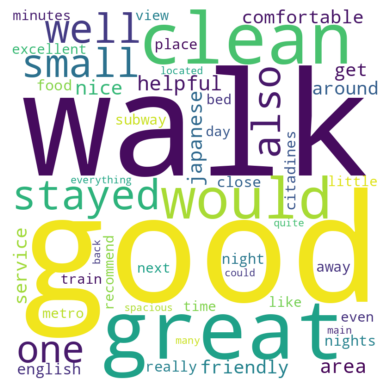

In [ ]:
topkGroundPos = getTopK(itemAnalysisDf, 50, label_value='positive')
plotWordCloud(dict(topkGroundPos), **wordcloud_args)

#### (ii)

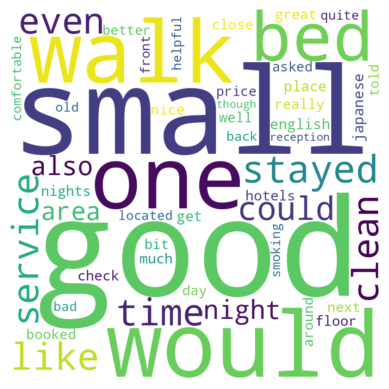

In [ ]:
topkGroundNeg = getTopK(itemAnalysisDf, 50, label_value='negative')
plotWordCloud(dict(topkGroundNeg), **wordcloud_args)

I included location-specific words in the list of stop words so they don't show, but they would be words like Shinjuku, Fuji, Tokyo, Japan, Japanese, etc. Some words that appear in both positive and negative reviews are 'good', 'walk', 'stayed', 'clean'.

'good' and 'clean' surprise me because they are words that are quite positive so they typically would not be in negative hotel reviews, but considering the criteria for a negative hotel review is 3 stars and under, I could see a lot of 3 star reviews using those words.

### topk noun phrases


In [ ]:
grammar = r"""
NBAR:
{<NN.*|JJ>*<NN.*>} # Nouns and Adjectives, terminated with Nouns
NP:
{<NBAR><IN><NBAR>}
{<NBAR>} # Above, connected with in/of/etc...
"""


chunker = nltk.RegexpParser(grammar)
tagger = PerceptronTagger()
pos_tag = tagger.tag

# to make the results more useable, we clean up the tree results shown above.
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()
stopword_list = get_stop_words()

# generator, create item one a time
def get_terms(tree, remove_stopwords=True):
    for leaf in leaves(tree):

        term = []

        for w, t in leaf:
            if remove_stopwords:
                if acceptable_word(w):
                    term.append(normalise(w))

            else:
                term.append(normalise(w))

        # Phrase only
        if len(term) > 1:
            yield term

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case...
def normalise(word,lemmatizer=lemmatizer, stemmer=stemmer):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word, stopword_list=stopword_list):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40)
        #and word.lower() not in stopword_list)
    return accepted

# Flatten phrase lists to get tokens for analysis
def flatten_phrase_lists(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        if len(token) > 0: # don't return empty tokens
            finalList.append(token.rstrip())
    return finalList

def getTopKNP(df, kNPs, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):

    counter = Counter()
    reviews = df.loc[operation(df[label_column],label_value)][value_column]

    for review in reviews:
            counter.update(flatten_phrase_lists([word
                            for word
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review))))
                            ]))
    topk = counter.most_common(kNPs)
    return topk

#### (i)

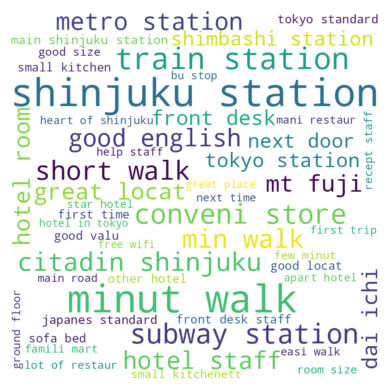

In [ ]:
topkNPPos = getTopKNP(itemAnalysisDf, 50, label_value='positive')
plotWordCloud(dict(topkNPPos), **wordcloud_args)

In [ ]:
topkNPPos[:10]

[('shinjuku station', 190),
 ('minut walk', 188),
 ('train station', 105),
 ('subway station', 87),
 ('conveni store', 86),
 ('short walk', 77),
 ('min walk', 74),
 ('citadin shinjuku', 74),
 ('metro station', 65),
 ('good english', 64)]

#### (ii)

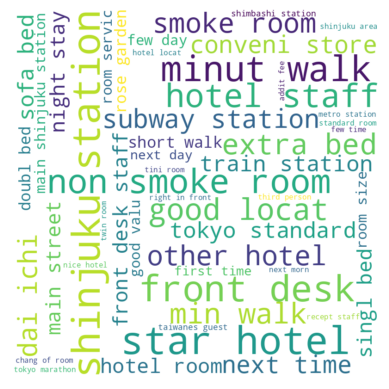

In [ ]:
topkNPNeg = getTopKNP(itemAnalysisDf, 50, label_value='negative')
plotWordCloud(dict(topkNPNeg), **wordcloud_args)

In [ ]:
topkNPNeg[:10]

[('shinjuku station', 18),
 ('star hotel', 18),
 ('front desk', 16),
 ('minut walk', 15),
 ('non smoke room', 14),
 ('hotel staff', 13),
 ('good locat', 11),
 ('extra bed', 10),
 ('min walk', 10),
 ('smoke room', 9)]

Many noun phrases appear in both positive and negative reviews such as 'front desk', 'min walk', 'non smoke', and 'conveni store'. A noun phrase I did not expect to see in the positive reviews is 'next door', which in context may be complaining about something that may be bothering them from a room nearby.

### topk noun phrases with propositions

In [ ]:
grammar = r"""
NBAR:
{<NN.*|JJ>*<NN.*>} # Nouns and Adjectives, terminated with Nouns
NP:
{<NBAR><IN><NBAR>}
"""
 # got rid of the {NBAR} under NP so it only looks at the NBARS with preposition separating them
chunker = nltk.RegexpParser(grammar)



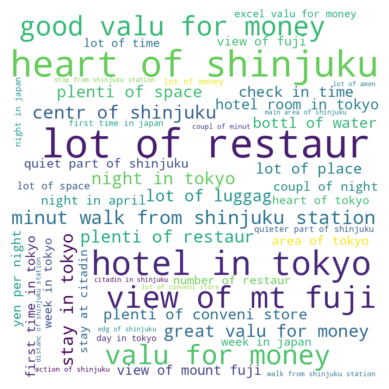

In [ ]:
topkNPPos_v2 = getTopKNP(itemAnalysisDf, 50, label_value='positive')
plotWordCloud(dict(topkNPPos_v2), **wordcloud_args)

In [ ]:
topkNPPos_v2[:10]

[('lot of restaur', 27),
 ('heart of shinjuku', 26),
 ('hotel in tokyo', 22),
 ('view of mt fuji', 18),
 ('good valu for money', 14),
 ('valu for money', 14),
 ('minut walk from shinjuku station', 11),
 ('centr of shinjuku', 10),
 ('night in tokyo', 9),
 ('great valu for money', 9)]

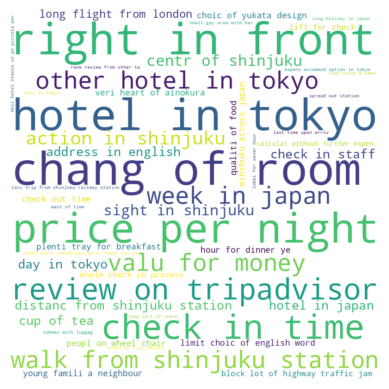

In [ ]:
topkNPNeg_v2 = getTopKNP(itemAnalysisDf, 50, label_value='negative')
plotWordCloud(dict(topkNPNeg_v2), **wordcloud_args)

In [ ]:
topkNPNeg_v2[:10]

[('chang of room', 3),
 ('right in front', 3),
 ('hotel in tokyo', 3),
 ('price per night', 3),
 ('check in time', 2),
 ('review on tripadvisor', 2),
 ('walk from shinjuku station', 2),
 ('other hotel in tokyo', 2),
 ('valu for money', 2),
 ('week in japan', 2)]



1.   The grammar from part (c) only takes nouns with prepositions between them which allows us to look at more specific and detailed phrases which can allow for a deeper sentiment analysis
2.   Because the requirements in the grammar from (c) are more specific, they retrieve less overall phrases, losing some data
3.   The grammar from part (b) has simpler phrases with more adjectives while the grammar from part (c) only sometimes has adjectives attached to their longer noun phrases, so it is a give and take.

Overall, I think that (c) is more effective for sentiment analysis because it gets more detailed noun phrases which can better describe the reviewer's sentiment, although at the loss of some data due to it not accepting the simple noun phrases too.

# Mutual Information


### World cloud of words ranked by mutual information


In [ ]:
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

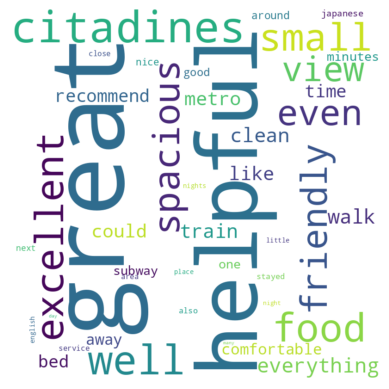

In [ ]:
miScoredf = getMI(top50, finaldf_50)
plotWordCloud(miScoredf.set_index('Word')['MI Score'].to_dict(), **wordcloud_args)

The words that get the highest MI values are great, helpful, citadines, well, and food. It makes sense that these words get high MI values because a lot of the words previously mentioned give a lot of information on determining if the review is positive or negative.

#### code to get top k noun phrases w/ most effective grammar:

In [ ]:
# to make the results more useable, we clean up the tree results shown above.
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()
stopword_list = get_stop_words()

grammar = r"""
NBAR:
{<NN.*|JJ>*<NN.*>} # Nouns and Adjectives, terminated with Nouns
NP:
{<NBAR><IN><NBAR>}
"""
 # got rid of the {NBAR} under NP so it only looks at the NBARS with preposition separating them
chunker = nltk.RegexpParser(grammar)

# generator, create item one a time
def get_terms(tree, remove_stopwords=True):
    for leaf in leaves(tree):

        term = []

        for w, t in leaf:
            if remove_stopwords:
                if acceptable_word(w):
                    term.append(normalise(w))

            else:
                term.append(normalise(w))

        # Phrase only
        if len(term) > 1:
            yield term

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case...
def normalise(word,lemmatizer=lemmatizer, stemmer=stemmer):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word, stopword_list=stopword_list):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopword_list)
    return accepted

# Flatten phrase lists to get tokens for analysis
def flatten_phrase_lists(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        if len(token) > 0: # don't return empty tokens
            finalList.append(token.rstrip())
    return finalList

def getTopKNP(df, kNPs):

    counter = Counter()
    reviews = df['reviewCol'].values

    for review in reviews:
            counter.update(flatten_phrase_lists([word
                            for word
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review))))
                            ]))
    topk = counter.most_common(kNPs)
    return topk


def NPdataFrameTransformation(hotelDf, reviewDF, topk):
    reviews = reviewDF['reviewCol'].values

    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten_phrase_lists([word
                                       for word
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)


    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return finaldf

### word cloud of noun phrases ranked by mutual information


In [ ]:
topk_phrase = getTopKNP(finaldf, 50)
finaldf_phrase = NPdataFrameTransformation(filtered_df, reviewDF, topk_phrase)

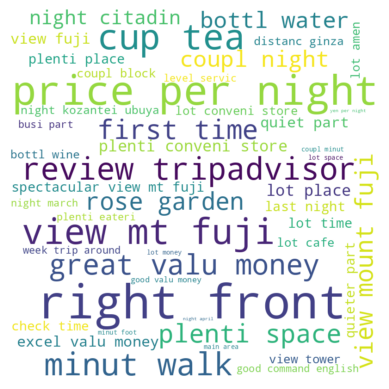

In [ ]:
miScoredf_phrase = getMI(topk_phrase, finaldf_phrase)
plotWordCloud(miScoredf_phrase.set_index('Word')['MI Score'].to_dict(), **wordcloud_args)

The noun phrases that got the highest MI values are 'right front', 'price per night', 'view mt fuji', 'cup tea', and 'minut walk'. Based on these results, one potential thing that hotels in Shirakawa might need to improve on are the pricing although even this is unclear as 'price per night' could have been prefixed with a word like 'cheap' or 'low'. Overall though, most of these noun phrases are likely to be placed within a positive context as there are a lot of compliments about there being a great value for their money, great view, short walks, etc.

# Pointwise Mutual Information

### topk words ranked by PMI

In [ ]:
def pmiForAllCal(df, topk_word, gt_sentiment, label_column='groundTruth'):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe

    index = [x[0] for x in topk_word]
    pmiDf = pd.DataFrame(index=index, columns=['pmi'])

    for (word, count) in tqdm(topk_word):
        pmiDf.at[word, 'pmi'] = pmiCalc(df,word,gt_sentiment,label_column)

    return pmiDf


def pmiCalc(df, word, gt_sentiment, label_column='groundTruth'):

    N = df.shape[0]

    px = sum(df[label_column]==gt_sentiment)
    py = sum(df[word]==True)
    pxy = len(df[(df[label_column]==gt_sentiment) & (df[word]==True)])
    #print(px, py, pxy)
    if pxy==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.0001)*N/(px*py))
    else:
        pmi = math.log(pxy*N/(px*py))
    return pmi

#### (i)

100%|██████████| 500/500 [00:01<00:00, 394.97it/s]


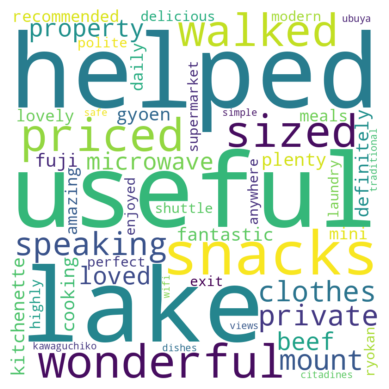

In [ ]:
pmiposdf = pmiForAllCal(finaldf,topk,'positive')
pmiposdf = pmiposdf.sort_values('pmi', ascending=0).iloc[0:50]
plotWordCloud(pmiposdf['pmi'].to_dict(), **wordcloud_args)

#### (ii)

100%|██████████| 500/500 [00:01<00:00, 352.50it/s]


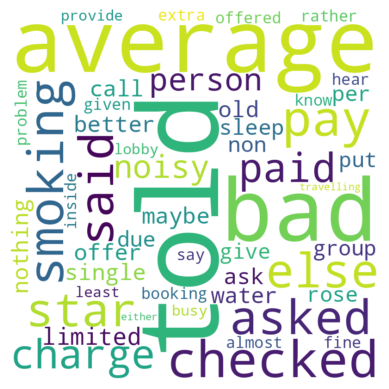

In [ ]:
pminegdf = pmiForAllCal(finaldf,topk,'negative')
pminegdf = pminegdf.sort_values('pmi', ascending=0).iloc[0:50]
plotWordCloud(pminegdf['pmi'].to_dict(), **wordcloud_args)



1.   One very positive word is 'lake' which might mean that there was a lake near some of the hotels that the reviewrs really liked.
2.   You can easily see the shortcomings of the negatively reviewed hotels by looking at the wordcloud - words like pay, smoking, noisy, average are some of the big ones.
3.   You can see what makes the positively reviewed hotels better than the negatively reviewed hotels by looking at the positive wordcloud with words like helped, useful, snacks, microwave, polite.


### topk noun phrases ranked by PMI

In [ ]:
topk_phrase = getTopKNP(finaldf, 500)
finaldf_phrase = NPdataFrameTransformation(filtered_df, reviewDF, topk_phrase)

100%|██████████| 500/500 [00:01<00:00, 496.45it/s]


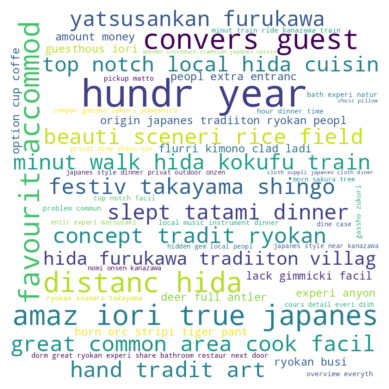

In [ ]:
pmiposdf_phrase = pmiForAllCal(finaldf_phrase,topk_phrase,'positive')
pmiposdf_phrase = pmiposdf_phrase.sort_values('pmi', ascending=0).iloc[0:50]
plotWordCloud(pmiposdf_phrase['pmi'].to_dict(), **wordcloud_args)

100%|██████████| 500/500 [00:01<00:00, 316.57it/s]


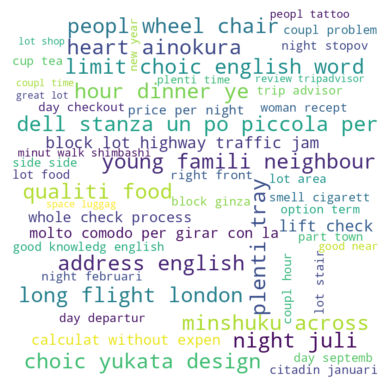

In [ ]:
pminegdf_phrase = pmiForAllCal(finaldf_phrase,topk_phrase,'negative')
pminegdf_phrase = pminegdf_phrase.sort_values('pmi', ascending=0).iloc[0:50]
plotWordCloud(pminegdf_phrase['pmi'].to_dict(), **wordcloud_args)

1.   The results are much more detailed and specific, for example looking at the positive review word cloud phrases like 'beauti scener', 'great common area', 'amaz iori true japanese', etc.
2.   The word cloud is much more evenly distributed meaning that most phrases occur a similar number of times, so maybe more data would be able to show a more significant pattern.
3.   Just like with the analysis in (a), looking at the negative cloud can give a summary of the problems of the negatively reviewed hotels except in this word cloud the problems are much more detailed such as 'limit choice english word', 'peopl wheel chair', 'block lot highway traffic', etc.

### single top and single bottom hotel pmi analyzation

In [ ]:
top_hotel = gt_asc.iloc[-2].name
bot_hotel = gt_asc.iloc[0].name
#topk_top = getTopKWords(reviewDF, 50)
#finaldf_top = dataFrameTransformation(filtered_df, reviewDF, topk)


In [ ]:
filtered_df_top = filtered_df[filtered_df['hotelName'] == top_hotel].reset_index(drop=True)
filtered_df_bot = filtered_df[filtered_df['hotelName'] == bot_hotel].reset_index(drop=True)
reviews_top = filtered_df_top['reviewColumn']
reviews_bot = filtered_df_bot['reviewColumn']
reviewDF_top = evalSentences(reviews_top, columns=['reviewCol', 'Vader'])
reviewDF_bot = evalSentences(reviews_bot, columns=['reviewCol', 'Vader'])
topk_top = getTopKWords(reviewDF_top, 50)
topk_bot = getTopKWords(reviewDF_bot, 50)
finaldf_top = dataFrameTransformation(filtered_df_top, reviewDF_top, topk_top)
finaldf_bot = dataFrameTransformation(filtered_df_bot, reviewDF_bot, topk_bot)

100%|██████████| 9/9 [00:00<00:00, 343.16it/s]


#### (c): top hotel

In [ ]:
pmiposdf_top = pmiForAllCal(finaldf_top,topk_top,'positive')
pmiposdf_top = pmiposdf_top.sort_values('pmi', ascending=0).iloc[0:50]
# plotWordCloud(pmiposdf_top['pmi'].to_dict(), **wordcloud_args)

100%|██████████| 50/50 [00:00<00:00, 873.26it/s]


Because all of the reviews of the top hotel are positive, the pmi of each word is 0 so we cannot gain any useful hotel-specific insights about what is good/bad about this hotel through this method.

(c): bot hotel

In [ ]:
pmiposdf_bot = pmiForAllCal(finaldf_bot,topk_bot,'positive')
pmiposdf_bot = pmiposdf_bot.sort_values('pmi', ascending=0).iloc[0:50]
pminegdf_bot = pmiForAllCal(finaldf_bot,topk_bot,'negative')
pminegdf_bot = pminegdf_bot.sort_values('pmi', ascending=0).iloc[0:50]

100%|██████████| 50/50 [00:00<00:00, 1172.06it/s]


(c) bot hotel part q4a)

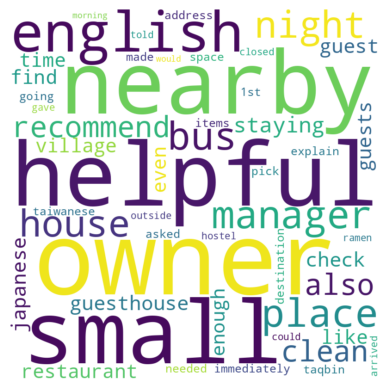

In [ ]:
wordcloud_dict_pos = pmiposdf_bot['pmi'].to_dict() # workaround for plotwordcloud bug that does not accept negative values due to font bug
min_value = min(wordcloud_dict_pos.values())
constant = 1
pos_dict = {key: value - min_value + constant for key, value in wordcloud_dict_pos.items()}
plotWordCloud(pos_dict, **wordcloud_args)

In [ ]:
def workaround_wordcloud(pmi):
  word_dict = pmi['pmi'].to_dict() # workaround for plotwordcloud bug that does not accept negative values due to font bug
  min_value = min(word_dict.values())
  constant = 1
  return {key: value - min_value + constant for key, value in word_dict.items()}

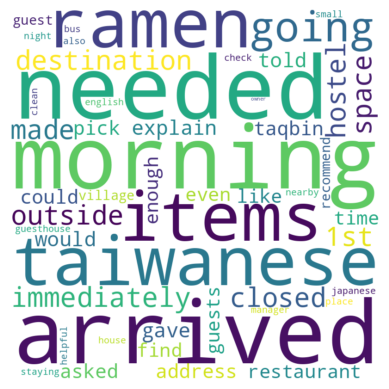

In [ ]:
plotWordCloud(workaround_wordcloud(pminegdf_bot), **wordcloud_args)


(c) bot hotel part q4b)

100%|██████████| 18/18 [00:00<00:00, 944.25it/s]


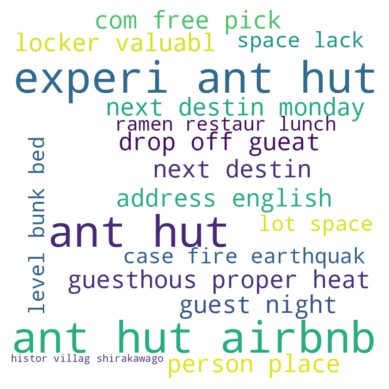

In [ ]:
topk_phrase_bot = getTopKNP(finaldf_bot, 50)
finaldf_phrase_bot = NPdataFrameTransformation(filtered_df_bot, reviewDF_bot, topk_phrase_bot)
pmiposdf_phrase_bot = pmiForAllCal(finaldf_phrase_bot,topk_phrase_bot,'positive')
plotWordCloud(workaround_wordcloud(pmiposdf_phrase_bot), **wordcloud_args)

100%|██████████| 18/18 [00:00<00:00, 977.12it/s]


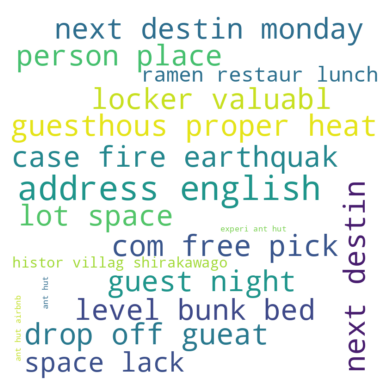

In [ ]:
pminegdf_phrase_bot = pmiForAllCal(finaldf_phrase_bot,topk_phrase_bot,'negative')
plotWordCloud(workaround_wordcloud(pminegdf_phrase_bot), **wordcloud_args)

Some insights can be made about what is good and bad about the bottom rated average GT rating hotel, such as that it has proper heat, and a locker, but also that it has a lack of space, etc. Deeper insights cannot be made because there are only 35 reviews of this hotel so in terms of phrases these are all phrases that have occurred once whereas in a hotel with much more reviews certain phrases would occur several times and a more confident insight and conclusion can be made.

# General Plots

### Histogram

In [ ]:
def getHistogram(df, measure, title,figsize=(10,5)):
    fig = plt.figure(figsize=figsize)
    plt.title(title)

    if measure=='both':
        x = [df['ratingScore'].values/5]
        y = [df['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.hist(x, bins, label='normalized Ground Truth')
        plt.hist(y, bins, label='vader')
        plt.legend(loc='upper right')
        plt.xlabel("Value")
        plt.ylabel("Frequency")
    else:
        plt.hist(df[measure].values)

    plt.xlabel("Value")
    plt.ylabel("Frequency")

#### (i)

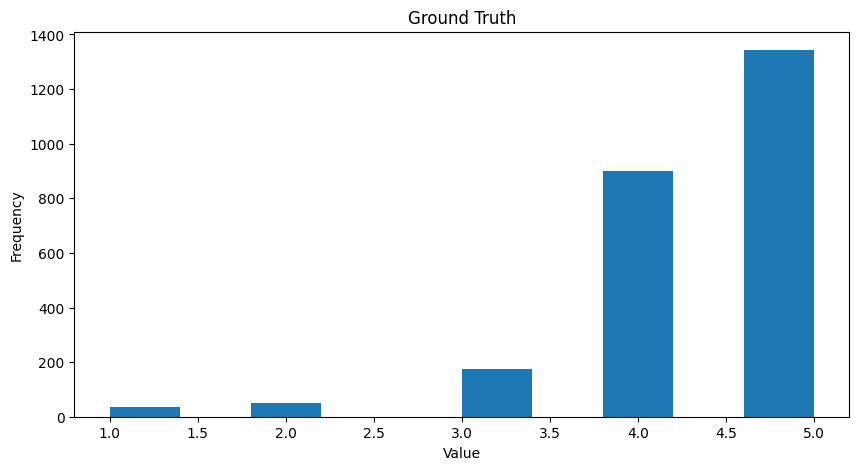

In [ ]:
getHistogram(finaldf,'ratingScore', 'Ground Truth')

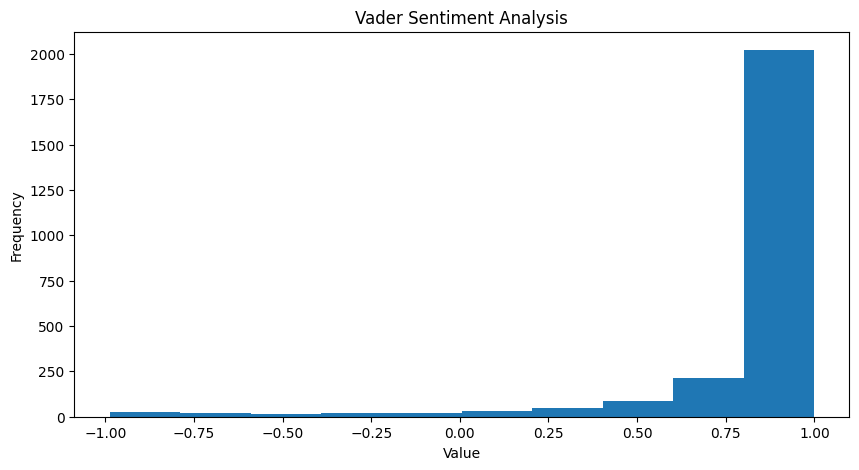

In [ ]:
getHistogram(finaldf, 'Vader', 'Vader Sentiment Analysis')

Vader rates 4 star and 5 star reviews more similarly than how proportional 4 is to 5 numerically. Other than that, everything is as expected with a overall positive distribution for both vader and ground truth.

#### (ii)

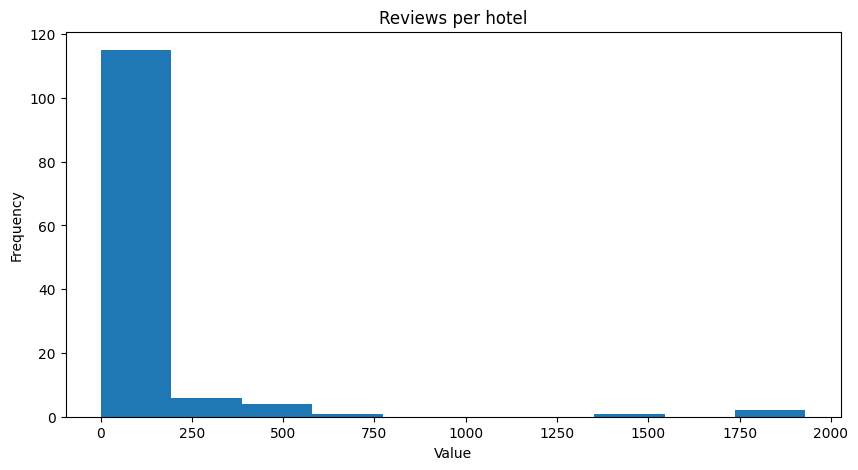

In [ ]:
hotel_counts = hotelDf['hotelName'].value_counts()
hotel_counts_df = hotel_counts.reset_index()
hotel_counts_df.columns = ['hotelName', 'reviewCount']
getHistogram(hotel_counts_df,'reviewCount', 'Reviews per hotel')

Most hotels in the Shirakawa region have a review count of around 0-250, with some outliers, showing that this region is a smaller region in terms of how many people are at the hotels.

#### (iii) - Ubuya not in rankings obtained from Q1(b)(ii) and Q1(b)(iii)






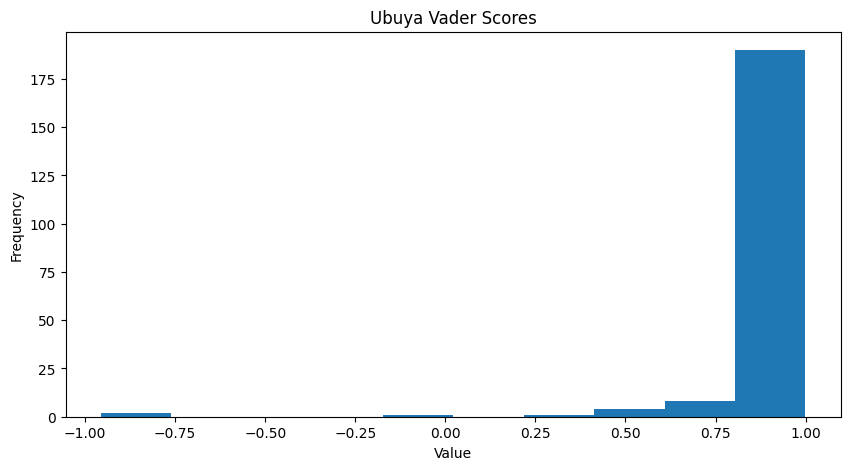

In [ ]:
Ubuya_Vader = finaldf[finaldf['hotelName'] == 'Ubuya']['Vader'].reset_index()
getHistogram(Ubuya_Vader, 'Vader', 'Ubuya Vader Scores')

### Boxplots

#### (i)

<Axes: title={'center': 'Vader Sentiment Ratings'}>

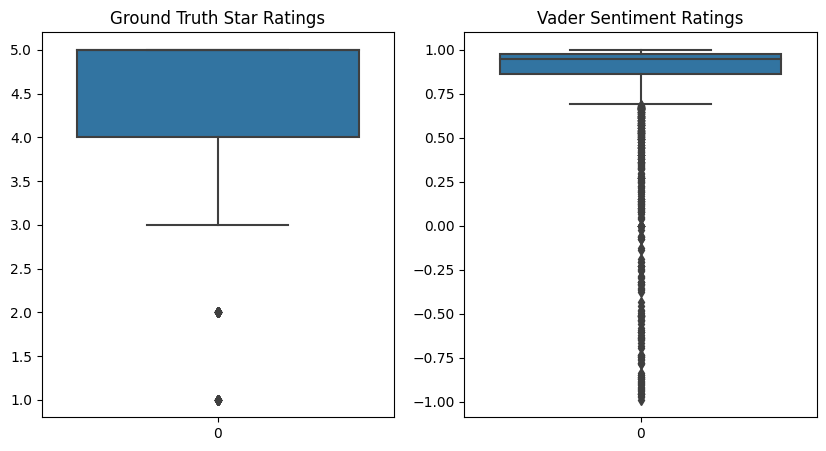

In [ ]:
gt_data = finaldf['ratingScore']
v_data = finaldf['Vader']
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].title.set_text('Ground Truth Star Ratings')
ax[1].title.set_text('Vader Sentiment Ratings')
sns.boxplot(gt_data,ax=ax[0])
sns.boxplot(v_data,ax=ax[1])


#### (ii)

In [ ]:
print(f"The ground truth mean is {gt_data.mean()} and the variance is {gt_data.var()}")
print(f"The Vader sentiment score mean is {v_data.mean()} and the variance is {v_data.var()}")

The ground truth mean is 4.383632734530938 and the variance is 0.6670642740078947
The Vader sentiment score mean is 0.8292292215568863 and the variance is 0.10890478543968932


#### (iii)

Overall, the box plot is more informative as it gives us a better understanding of the distribution of the data, especially with the fact that the data is asymmetric and has plenty of outliers. One downside is that the outliers are quite messily displayed as seen more prominently in the vader sentiment score where the "fliers" occupy practically the whole range due to the fact that the number of ratings is extremely high so there are hundreds of outliers.

### Scatterplots and heatmaps

#### (i)

Text(0.5, 1.0, 'Rating vs Vader - heatmap')

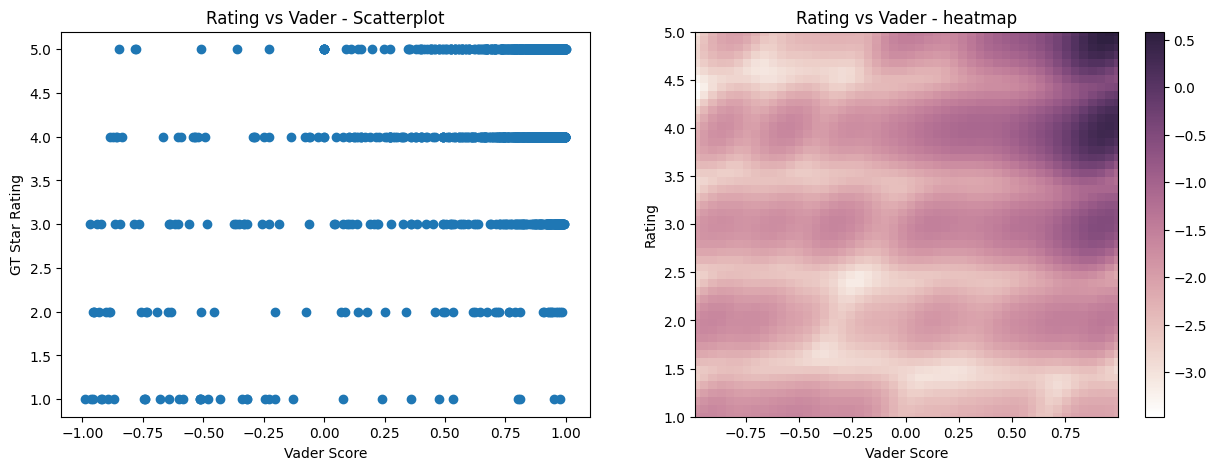

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5), sharex=False, sharey=False)
rating_scores = gt_data.values
vader_scores = v_data.values
ax[0].plot(vader_scores, rating_scores, "o")
ax[0].set_xlabel('Vader Score')
ax[0].set_ylabel('GT Star Rating')
ax[0].set_title('Rating vs Vader - Scatterplot')

k = gaussian_kde(np.vstack([vader_scores, rating_scores]))
xi, yi = np.mgrid[vader_scores.min():vader_scores.max():vader_scores.size**0.5*1j,rating_scores.min():rating_scores.max():rating_scores.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
b1 = ax[1].pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax[1].set_xlim(vader_scores.min(), vader_scores.max())
ax[1].set_ylim(rating_scores.min(), rating_scores.max())
ax[1].set_xlabel('Vader Score')
ax[1].set_ylabel('Rating')
fig.colorbar(b1, ax=ax[1])
ax[1].set_title('Rating vs Vader - heatmap')


I notice that for the higher GT ratings, the Vader score is more dense on the righthandside of the axis, meaning that for more positive ground truth ratings Vader is able to correctly predict the label. For lower GT ratings, Vader is slightly more dense on the left meaning the same thing as above but vice versa. Additionally, Vader seems to rate reviews slightly higher on average than the star rating, seeing as for star ratings of 3, 4, and 5, there are a lot of dense points on the very right at approximately 0.9-1.0.

#### (ii)

In [ ]:
review_lengths = filtered_df['reviewColumn'].apply(len).values

Text(0.5, 1.0, 'Review Length vs Rating - heatmap')

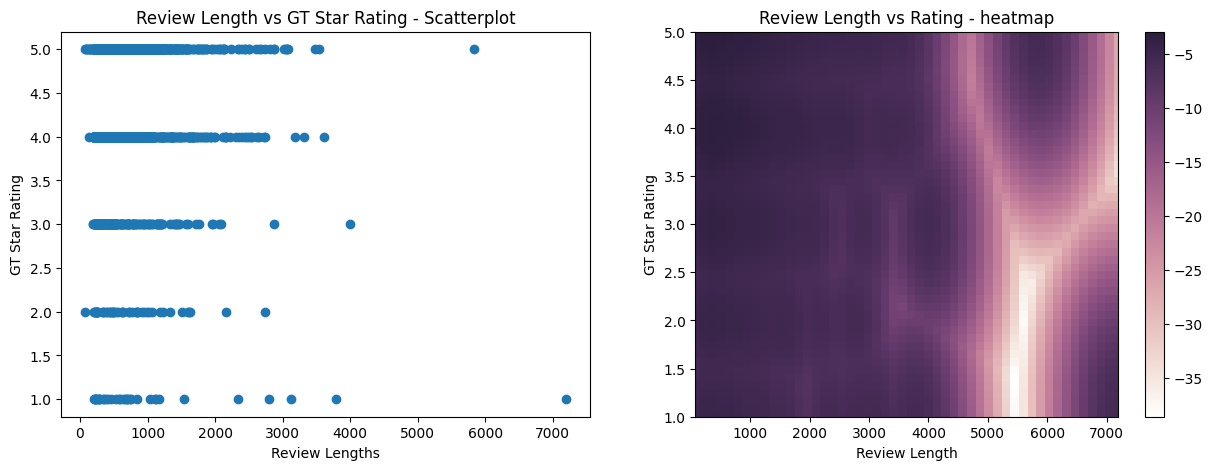

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5), sharex=False, sharey=False)
ax[0].plot(review_lengths, rating_scores, "o")
ax[0].set_xlabel('Review Lengths')
ax[0].set_ylabel('GT Star Rating')
ax[0].set_title('Review Length vs GT Star Rating - Scatterplot')

k = gaussian_kde(np.vstack([review_lengths, rating_scores]))
xi, yi = np.mgrid[review_lengths.min():review_lengths.max():review_lengths.size**0.5*1j,rating_scores.min():rating_scores.max():rating_scores.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
b1 = ax[1].pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax[1].set_xlim(review_lengths.min(), review_lengths.max())
ax[1].set_ylim(rating_scores.min(), rating_scores.max())
ax[1].set_xlabel('Review Length')
ax[1].set_ylabel('GT Star Rating')
fig.colorbar(b1, ax=ax[1])
ax[1].set_title('Review Length vs Rating - heatmap')

Text(0.5, 1.0, 'Review Length vs Vader Sentiment Rating - heatmap')

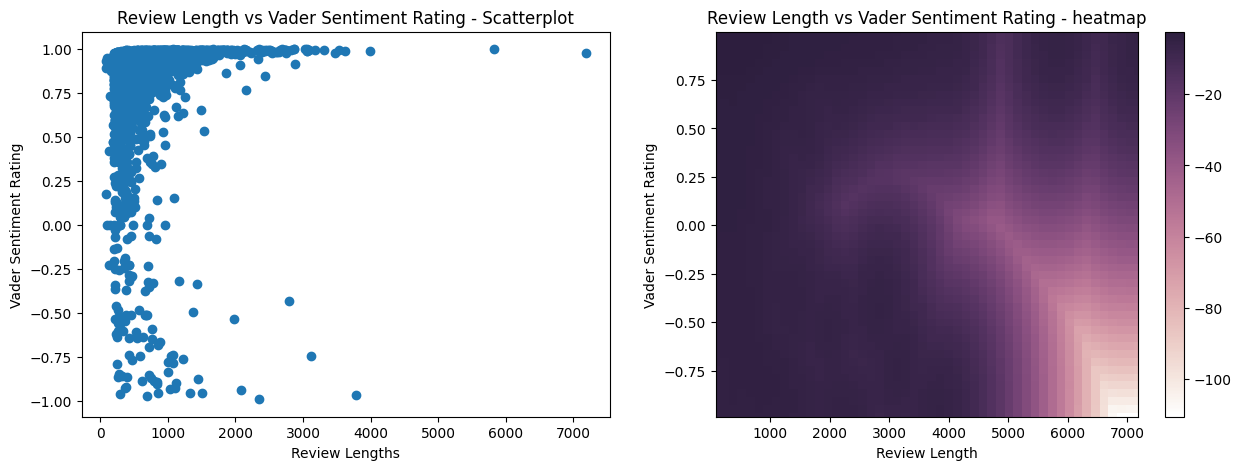

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5), sharex=False, sharey=False)
ax[0].plot(review_lengths, vader_scores, "o")
ax[0].set_xlabel('Review Lengths')
ax[0].set_ylabel('Vader Sentiment Rating')
ax[0].set_title('Review Length vs Vader Sentiment Rating - Scatterplot')

k = gaussian_kde(np.vstack([review_lengths, vader_scores]))
xi, yi = np.mgrid[review_lengths.min():review_lengths.max():review_lengths.size**0.5*1j,vader_scores.min():vader_scores.max():vader_scores.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
b1 = ax[1].pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax[1].set_xlim(review_lengths.min(), review_lengths.max())
ax[1].set_ylim(vader_scores.min(), vader_scores.max())
ax[1].set_xlabel('Review Length')
ax[1].set_ylabel('Vader Sentiment Rating')
fig.colorbar(b1, ax=ax[1])
ax[1].set_title('Review Length vs Vader Sentiment Rating - heatmap')

1.   Approximately a uniform distribution of review length, but the range of the distribution increases as the GT Star Rating / Vader Sentiment Rating gets larger.
2.   Can conclude that negative reviews tend to be shorter while positive comments can either be short or long.

#### (iii)

Text(0.5, 1.0, 'Review Count vs Average Vader Sentiment Rating - Scatterplot')

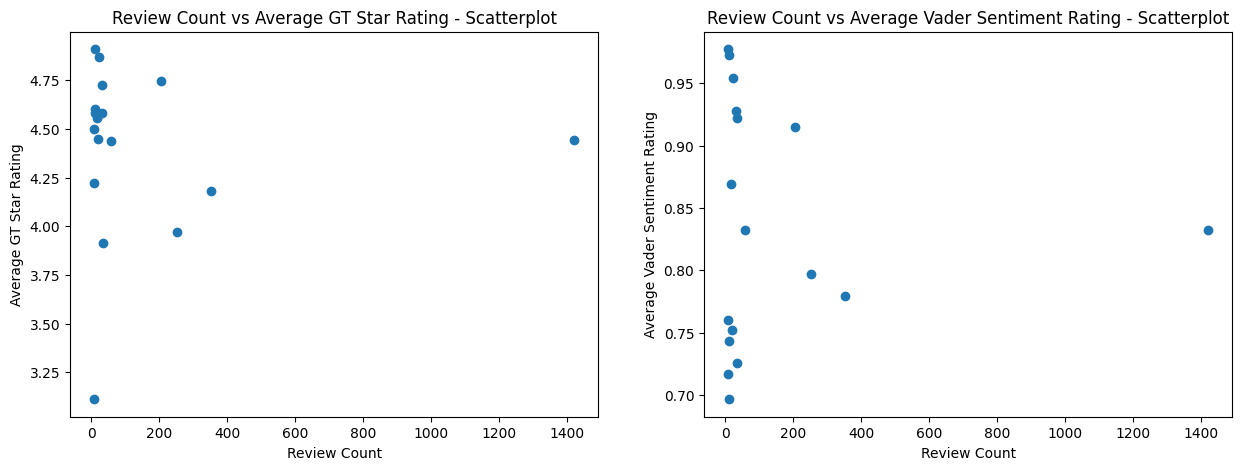

In [ ]:
review_counts = filtered_df.groupby('hotelName').count()['filePath'].values
avg_GT_score = avg_rating_df['AverageRatingScore'].values
avg_v_score = avg_rating_df['AverageVader'].values
fig, ax = plt.subplots(1,2,figsize=(15,5), sharex=False, sharey=False)
ax[0].plot(review_counts, avg_GT_score, "o")
ax[0].set_xlabel('Review Count')
ax[0].set_ylabel('Average GT Star Rating')
ax[0].set_title('Review Count vs Average GT Star Rating - Scatterplot')

ax[1].plot(review_counts, avg_v_score, "o")
ax[1].set_xlabel('Review Count')
ax[1].set_ylabel('Average Vader Sentiment Rating')
ax[1].set_title('Review Count vs Average Vader Sentiment Rating - Scatterplot')


1.   Overall there is a lack of any trend as most hotels in the region simply are typically positively rated in terms of GT and Vader and have less than 200 reviews because Shirakawa is a smaller town.
2.   There is one major outlier, namely Citadines Shinjuku Tokyo, which managed to slip into the scraper which has many more reviews due to it being a hotel in a much larger city.

### Location-based patterns

In [ ]:
def make_address(row):
  # individual columns need to be combined
  return row['streetAddress']+", "+row['City']+", "+row['Province']

In [ ]:
geo_rating_df = avg_rating_df\
                         .join(filtered_df.groupby('hotelName')\
                         .agg({'streetAddress':'max','City':'max','Province':'max','postalCode':'max'}))

geo_rating_df['formed_address'] = geo_rating_df.apply(make_address , axis=1)          # MANUALLY ENTER IT? CODE DOES NOT WORK
locator = Photon(user_agent='myGeocoder')
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
geo_rating_df['location'] = geo_rating_df['formed_address'].apply(geocode)    # ---------GEOCODE DOES NOT WORK FOR JAPANESE ADDRESSES - DOING IT MANUALLY

#geo_rating_df['point'] = geo_rating_df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
points = [(36.426430594648465, 136.93644494033617, 0.0), (35.6912516049411, 139.71312769713217, 0.0), (35.66886263039006, 139.75741421247164, 0.0), (36.21850345711244, 137.20309210268226, 0.0), \
    (36.27226299511291, 136.89947263558247, 0.0), (35.675706310727406, 139.77088678363697, 0.0), (35.69462583862015, 139.6937380836375, 0.0), (36.44400287709517, 136.54440179530937, 0.0), \
    (36.42592823190461, 136.9352456106517, 0.0), (35.69326388774054, 139.71101313761702, 0.0), (36.26630513102741, 136.90165421249117, 0.0), (36.26116106380503, 136.90627861080208, 0.0), \
    (36.26239224703725, 136.90619707385213, 0.0), (36.258136976118685, 136.8823044108015, 0.0), (35.51291803676074, 138.76891712596142, 0.0), (36.233150529472, 137.18777798180994, 0.0), \
    (36.42584312829447, 136.93574919715653, 0.0)]

geo_rating_df['point'] = points
geo_rating_df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(geo_rating_df['point'].tolist(), index=geo_rating_df.index)

geo_rating_df.head()

AverageVader  AverageRatingScore  n_reviews  \
hotelName                                                               
Choyomon                      0.717000            4.500000          8   
Citadines Shinjuku Tokyo      0.832114            4.440535       1421   
Dai-ichi Hotel Tokyo          0.779319            4.182336        351   
Guesethouse Iori              0.973073            4.909091         11   
Guesthouse Ant Hut            0.760544            3.111111          9   

                                     streetAddress                 City  \
hotelName                                                                 
Choyomon                              418 Ainokura           ('Nanto',)   
Citadines Shinjuku Tokyo          1-28-13 Shinjuku                ('',)   
Dai-ichi Hotel Tokyo                         1-2-6       ('Shimbashi',)   
Guesethouse Iori          145-1 Furukawacho Onocho            ('Hida',)   
Guesthouse Ant Hut                    450 Hatogaya  ('Shirakawa-mura',)   

                         Province postalCode  \
hotelName                                      
Choyomon                    Chubu   939-1915   
Citadines Shinjuku Tokyo    Kanto   160-0022   
Dai-ichi Hotel Tokyo        Kanto   105-8621   
Guesethouse Iori            Chubu   509-4255   
Guesthouse Ant Hut          Chubu   501-5629   

                                                      formed_address  \
hotelName                                                              
Choyomon                             418 Ainokura, ('Nanto',), Chubu   
Citadines Shinjuku Tokyo              1-28-13 Shinjuku, ('',), Kanto   
Dai-ichi Hotel Tokyo                    1-2-6, ('Shimbashi',), Kanto   
Guesethouse Iori          145-1 Furukawacho Onocho, ('Hida',), Chubu   
Guesthouse Ant Hut          450 Hatogaya, ('Shirakawa-mura',), Chubu   

                                                                   location  \
hotelName                                                                     
Choyomon                                                               None   
Citadines Shinjuku Tokyo  (13, 28 Pułku Strzelców Kaniowskich, 90-750, 2...   
Dai-ichi Hotel Tokyo      (6-2, Immanuel Kanthof, 1064VS, Immanuel Kanth...   
Guesethouse Iori                                                       None   
Guesthouse Ant Hut                                                     None   

                                                                  point  \
hotelName                                                                 
Choyomon                  (36.426430594648465, 136.93644494033617, 0.0)   
Citadines Shinjuku Tokyo    (35.6912516049411, 139.71312769713217, 0.0)   
Dai-ichi Hotel Tokyo       (35.66886263039006, 139.75741421247164, 0.0)   
Guesethouse Iori           (36.21850345711244, 137.20309210268226, 0.0)   
Guesthouse Ant Hut         (36.27226299511291, 136.89947263558247, 0.0)   

                           latitude   longitude  altitude  
hotelName                                                  
Choyomon                  36.426431  136.936445       0.0  
Citadines Shinjuku Tokyo  35.691252  139.713128       0.0  
Dai-ichi Hotel Tokyo      35.668863  139.757414       0.0  
Guesethouse Iori          36.218503  137.203092       0.0  
Guesthouse Ant Hut        36.272263  136.899473       0.0

In [ ]:
map1 = folium.Map(
    location=[36.261161,	136.906279], # <- this will need to be set based on your own hotels
    tiles='cartodbpositron',
    zoom_start=12,
)

# geo_rating_df.dropna().apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]], color='#d7191c').add_to(map1), axis=1)
# folium.CircleMarker(location=[36.261161,	136.906279], color='#d7191c').add_to(map1)
for index, row in geo_rating_df.iterrows():
    folium.CircleMarker(location=[row["latitude"], row["longitude"]], color='#d7191c').add_to(map1)

#map1

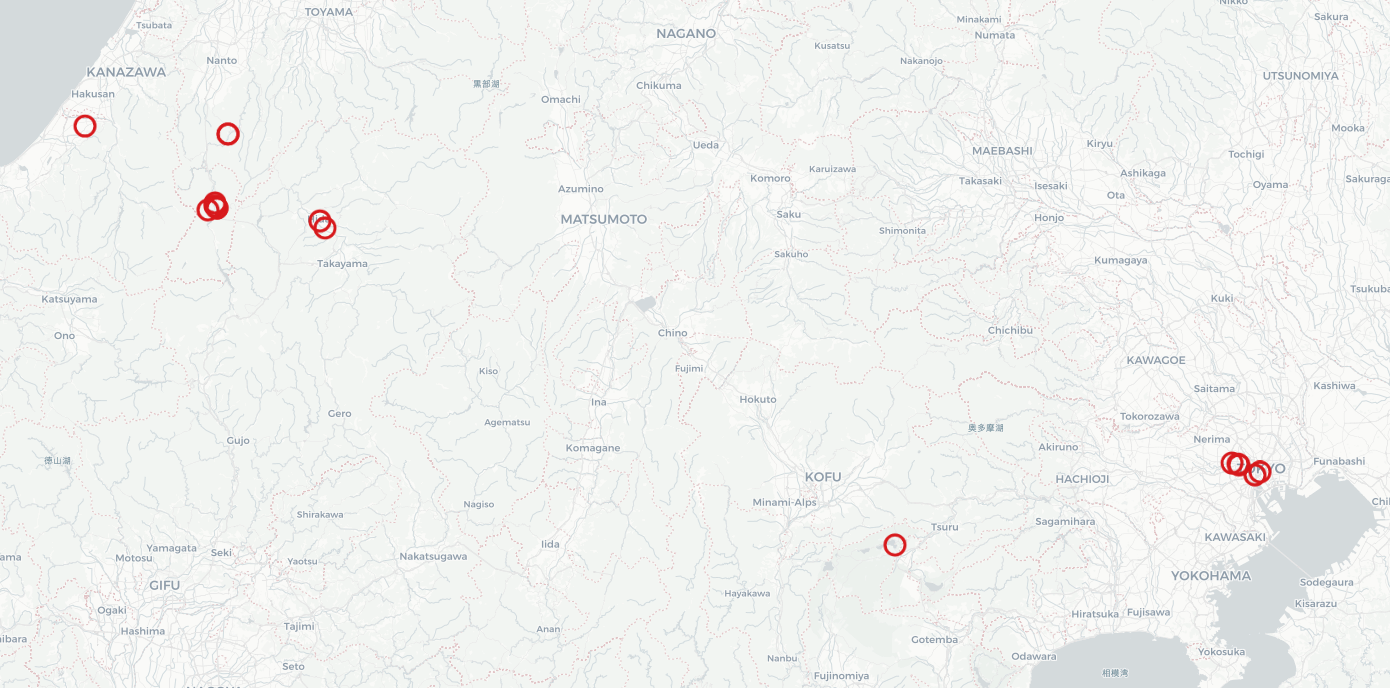

shirakawa is the condensed area of hotels at the upper left area. the bottom right area is tokyo

### Temporal Analysis

#### (i)

Text(0.5, 1.0, 'Average Rating of 6 Hotels Over Time')

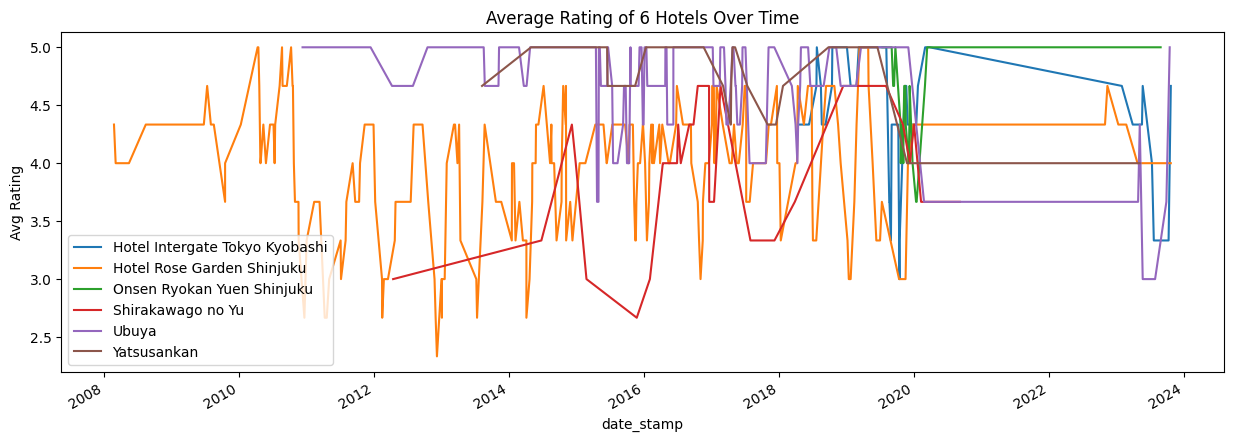

In [ ]:
six_hotels = avg_rating_df[(avg_rating_df['n_reviews'] > 30) & (avg_rating_df['n_reviews'] < 350)]
fig = plt.figure(figsize=(15,5))
for hotel in six_hotels.index.values:
  _df = filtered_df[filtered_df['hotelName']==hotel].set_index('date_stamp')
  _df.rename(index={'4 weeks ago': 'October 9, 2023'}, inplace=True)
  _df.rename(index={'3 weeks ago': 'October 15, 2023'}, inplace=True)
  _df.rename(index={'2 weeks ago': 'October 21, 2023'}, inplace=True)
  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()
  _df['count'] = 1
  _df['ratingScore'].rolling(3).mean().plot(label=hotel)
plt.ylabel('Avg Rating')
plt.legend(loc='lower left')
plt.title('Average Rating of 6 Hotels Over Time')

From observing the graph there seems to have been a lot of fluctuation over time for the highly rated and lowly rated hotels, seeing as for example Ubuya, which is one of the highly rated hotels was at an average rating of 5 5 years ago, to 3.5 a couple years ago then finally shot up to 4.7 just recently.

#### (ii)

Text(0.5, 1.0, 'Rate of Reviews of 6 Hotels Over Time')

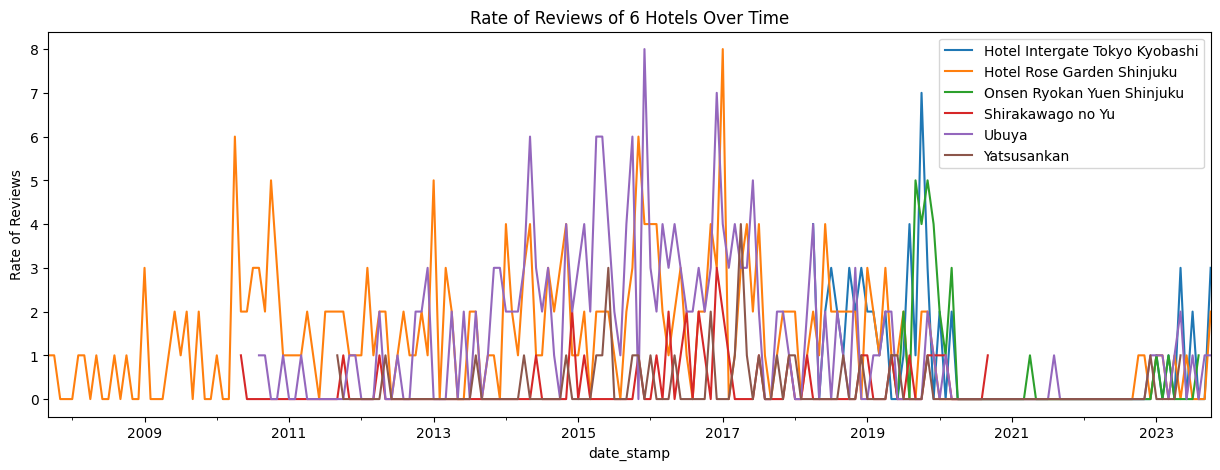

In [ ]:
fig = plt.figure(figsize=(15,5))
for hotel in six_hotels.index.values:
  _df = filtered_df[filtered_df['hotelName']==hotel].set_index('date_stamp')
  _df.rename(index={'4 weeks ago': 'October 9, 2023'}, inplace=True)
  _df.rename(index={'3 weeks ago': 'October 15, 2023'}, inplace=True)
  _df.rename(index={'2 weeks ago': 'October 21, 2023'}, inplace=True)
  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()

  _df['count'] = 1
  _df_monthly = _df.groupby(pd.Grouper(freq='M')).agg({'count':'sum','ratingScore':'mean'})
  _df_monthly['ratingScore'] = _df_monthly['ratingScore'].fillna(method='ffill') # hold the last rating constant in months with no reviews
  _df_monthly['count'].plot(label=hotel)
plt.ylabel('Rate of Reviews')
plt.legend(loc='upper right')
plt.title('Rate of Reviews of 6 Hotels Over Time')

One trend observed is that from 2015-2019 tourism was at an all time high, then from 2020-2022, tourism dropped severely. This can be attributed to covid-19 happening and Japan shutting their borders down which halted all tourism. Then, after borders opened back up in 2023 it can be observed that slowly the hotels have business again, but not at the same level as 2015-2019 yet.